# ML_Model1-- Loan Payment Prediction

###  Problem Statement: Produce a supervised machine learning model to predict whether a load will be paid in full or charged off

## Step One: Data processing and cleaning

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
import datetime as dt

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

Packages for model build:

In [2]:
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc

Load the data to Pandas:

In [3]:
#the uploaded file has low than 25MB, the original has to splitted into two parts
df=pd.read_csv('CaseStudy_Dataset2.csv')
df.head(5)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,22545,NaN,NaN,8500.0,8500.0,8450.00000,36 months,9.99%,274.24,B,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,22546,NaN,NaN,19000.0,19000.0,18975.00000,36 months,13.72%,646.80,C,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,22547,NaN,NaN,4000.0,4000.0,4000.00000,60 months,16.69%,98.75,E,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,22548,NaN,NaN,24250.0,17675.0,17431.82356,60 months,12.23%,395.23,C,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,22549,NaN,NaN,3600.0,3600.0,3600.00000,36 months,12.98%,121.27,C,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(20000, 145)

Check the column information:

In [5]:
list(df.columns)

['Unnamed: 0',
 'id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_a

Check the target variable - loan_status by using value_counts():

In [6]:
df['loan_status'].value_counts()

Fully Paid                                             14959
Charged Off                                             2289
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

Usually for loan applications which **didn't meet credit policy**, they should be declined directly before sent to the model.
Although, in this case these loans still had 'Status' information, we **would remove these records from build model and assume these loans won't be processed by the model** 

Only keep records which passed credit policy:

In [7]:
df=df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [8]:
df['loan_status'].value_counts()

Fully Paid     14959
Charged Off     2289
Name: loan_status, dtype: int64

Define a function to check missing values:

In [9]:
def missing_values_table(df):
        #1 Total missing values
        mis_val = df.isnull().sum()
        
        #2 Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #3 Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        #4 Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        #5 Only keep the columns with missing values
        mis_val_table_only = mis_val_table_ren_columns.loc[mis_val_table_ren_columns['% of Total Values'] > 0]
        
        #6 Return the dataframe with missing information
        return mis_val_table_only

In [10]:
#Apply the function to our dataframe:
missing=missing_values_table(df)
missing

,Missing Values,% of Total Values
id,17248,100.000000
member_id,17248,100.000000
emp_title,973,5.641234
emp_length,288,1.669759
url,17248,100.000000
...,...,...
settlement_status,17197,99.704314
settlement_date,17197,99.704314
settlement_amount,17197,99.704314
settlement_percentage,17197,99.704314


Usually there are three options to deal with missing values:
 1. Imputation
 2. Create missing flag
 3. Drop columns with a high percentage of missing vlaues

We see there are a number of columns with a high percentage of missing values. 
There is no well-established threshold for removing missing values, 

and the best course of action depends on the problem. 

Here, to reduce the number of features, we will remove any columns that have greater than 80% missing rate (in real situations, the threshold can be 98%).

In [11]:
# find columns with missing > 80%
missing_columns = list(missing.index[missing['% of Total Values'] > 80])
missing_columns

['id',
 'member_id',
 'url',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m

Drop these columns with missing rate > 80%:

In [12]:
df2 = df.drop(columns = missing_columns)
missing_values_table(df2)

,Missing Values,% of Total Values
emp_title,973,5.641234
emp_length,288,1.669759
desc,3671,21.283627
title,11,0.063776
mths_since_last_delinq,10816,62.708720
revol_util,40,0.231911
last_pymnt_d,33,0.191327
last_credit_pull_d,2,0.011596
collections_12_mths_ex_med,56,0.324675
chargeoff_within_12_mths,56,0.324675


Check duplicates in Pandas:

In [13]:
# DataFrame.duplicated(): Return boolean Series denoting duplicate rows
df2.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
17243    False
17244    False
17245    False
17246    False
17247    False
Length: 17248, dtype: bool

In [14]:
df2.loc[df2.duplicated()]

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag


Remove duplicates:

In [15]:
# DataFrame.drop_duplicates(): Return DataFrame with duplicate rows removed
  # inplace (bool, default False): Whether to drop duplicates in place or to return a copy
df2.drop_duplicates(inplace= True)
df2.shape

(17248, 55)

## Step Two: Exploratory Data Analysis

###### 2.1 Check whether the data is balanced or imbalanced

Practice:
1. Encode the target variable as 1 for 'Charged Off' and 0 for 'Fully Paid':
2. Calculate the charge off rate:

In [16]:
df2['target'] = df2['loan_status'].apply(lambda x:1 if x == 'Charged Off' else 0)

In [17]:
df2.target.sum() / df2.shape[0] * 100

13.271103896103897

The data is imbalanced

##### 2.2 Drop Columns May Cause Data Leakge
Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

In this case, we want to predict from the client's information whether the loan is "charged off" or "fully paid". The variables about the loan payment can fully infer the status of the loan, which is against the goal of prediction.

In [18]:
data_leakage_cols = ['funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
                     'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
                     'last_pymnt_amnt','chargeoff_within_12_mths','debt_settlement_flag']

In [19]:
df2.drop(columns=data_leakage_cols, inplace=True)

##### 2.3 Explore numerical features

Basic descriptive statistics view:

In [20]:
df2.describe()

,Unnamed: 0,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,...,total_acc,out_prncp,out_prncp_inv,collections_12_mths_ex_med,policy_code,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,target
count,17248.000000,17248.000000,17248.000000,1.724800e+04,17248.000000,17248.000000,17248.000000,6432.000000,17248.000000,17248.000000,...,17248.000000,17248.0,17248.0,17192.0,17248.0,17248.0,17248.0,16551.000000,17209.0,17248.000000
mean,31168.500000,10227.206053,308.455227,6.829683e+04,12.672873,0.144133,0.921382,34.708955,9.173643,0.056876,...,21.502377,0.0,0.0,0.0,1.0,0.0,0.0,0.041206,0.0,0.132711
std,4979.213057,6375.972589,196.981532,8.021522e+04,6.589699,0.471344,1.105954,22.569229,4.447792,0.244758,...,11.539355,0.0,0.0,0.0,0.0,0.0,0.0,0.199682,0.0,0.339272
min,22545.000000,500.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,2.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
25%,26856.750000,5000.000000,161.470000,4.000000e+04,7.590000,0.000000,0.000000,17.000000,6.000000,0.000000,...,13.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
50%,31168.500000,9000.000000,263.290000,5.649600e+04,12.790000,0.000000,1.000000,32.000000,8.000000,0.000000,...,20.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
75%,35480.250000,14500.000000,407.090000,8.000000e+04,17.900000,0.000000,2.000000,51.000000,12.000000,0.000000,...,28.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
max,39792.000000,25000.000000,950.120000,6.000000e+06,29.420000,7.000000,8.000000,107.000000,44.000000,4.000000,...,90.000000,0.0,0.0,0.0,1.0,0.0,0.0,2.000000,0.0,1.000000


In [21]:
df2['delinq_amnt'].value_counts()

0.0    17248
Name: delinq_amnt, dtype: int64

Drop columns with constant values:
- collections_12_mths_ex_med
- tax_liens
- out_prncp
- out_prncp_inv
- delinq_amnt
- acc_now_delinq 

In [22]:
df2.drop(columns=['collections_12_mths_ex_med','tax_liens','out_prncp','out_prncp_inv','delinq_amnt','acc_now_delinq'], inplace=True)

In [23]:
df2.shape

(17248, 38)

##### 2.5 Explore Categorical features

In [24]:
print(df2.info(0))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17248 entries, 0 to 17247
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              17248 non-null  int64  
 1   loan_amnt               17248 non-null  float64
 2   term                    17248 non-null  object 
 3   int_rate                17248 non-null  object 
 4   installment             17248 non-null  float64
 5   grade                   17248 non-null  object 
 6   sub_grade               17248 non-null  object 
 7   emp_title               16275 non-null  object 
 8   emp_length              16960 non-null  object 
 9   home_ownership          17248 non-null  object 
 10  annual_inc              17248 non-null  float64
 11  verification_status     17248 non-null  object 
 12  issue_d                 17248 non-null  object 
 13  loan_status             17248 non-null  object 
 14  pymnt_plan              17248 non-null

Create a separate DataFrame consisting of only categorical features:

In [25]:
df_cat=df2.select_dtypes(include=['object'])
df_cat.head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,...,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag
0,36 months,9.99%,B,B4,TCVCG,< 1 year,RENT,Not Verified,10-Dec,Fully Paid,...,tracy,071xx,NJ,Jan-74,80.10%,f,11-Jan,11-Jan,Individual,N
1,36 months,13.72%,C,C5,Santa Fe Springs Storage Park,10+ years,RENT,Verified,10-Dec,Fully Paid,...,Bye Bye BofA,906xx,CA,Sep-96,57.50%,f,12-Jun,12-Jul,Individual,N
2,60 months,16.69%,E,E3,NaN,NaN,RENT,Verified,10-Dec,Fully Paid,...,rita loan,330xx,FL,2-Jun,65.10%,f,15-Sep,15-Sep,Individual,N
3,60 months,12.23%,C,C1,Norfolk Southern Corp.,10+ years,MORTGAGE,Verified,10-Dec,Fully Paid,...,connie1958,450xx,OH,Jun-90,68.70%,f,13-Oct,13-Nov,Individual,N
4,36 months,12.98%,C,C3,Eaton drilling,4 years,MORTGAGE,Not Verified,10-Dec,Charged Off,...,Bill help,956xx,CA,7-Mar,33.60%,f,12-Sep,16-Oct,Individual,N


Drop the target column and create a list with all categorical columns:

In [26]:
cat_columns=list(df_cat.drop(columns=['loan_status']).columns)
cat_columns

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag']

Strip leading and trailing space of each categorical column:

In [27]:
for i in cat_columns:   
    df2[i] = df2[i].str.strip()

Quickly explore each each categorical feature and check the frequency:

In [28]:
pd.set_option('display.max_columns', None)
df2[cat_columns].head(5)

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag
0,36 months,9.99%,B,B4,TCVCG,< 1 year,RENT,Not Verified,10-Dec,n,Borrower added on 12/06/10 > I would like to c...,debt_consolidation,tracy,071xx,NJ,Jan-74,80.10%,f,11-Jan,11-Jan,Individual,N
1,36 months,13.72%,C,C5,Santa Fe Springs Storage Park,10+ years,RENT,Verified,10-Dec,n,Borrower added on 12/06/10 > I am planning on ...,credit_card,Bye Bye BofA,906xx,CA,Sep-96,57.50%,f,12-Jun,12-Jul,Individual,N
2,60 months,16.69%,E,E3,NaN,NaN,RENT,Verified,10-Dec,n,Borrower added on 12/08/10 > the funds are goi...,other,rita loan,330xx,FL,2-Jun,65.10%,f,15-Sep,15-Sep,Individual,N
3,60 months,12.23%,C,C1,Norfolk Southern Corp.,10+ years,MORTGAGE,Verified,10-Dec,n,NaN,credit_card,connie1958,450xx,OH,Jun-90,68.70%,f,13-Oct,13-Nov,Individual,N
4,36 months,12.98%,C,C3,Eaton drilling,4 years,MORTGAGE,Not Verified,10-Dec,n,NaN,debt_consolidation,Bill help,956xx,CA,7-Mar,33.60%,f,12-Sep,16-Oct,Individual,N


Check frequency:

In [29]:
for i in cat_columns:
    print(df2[i].value_counts().to_frame())
#for seperate columns:
#df2['emp_title'].value_counts()

            term
36 months  14433
60 months   2815
        int_rate
7.88%        725
7.51%        486
11.86%       392
7.14%        341
11.49%       336
...          ...
16.15%         1
16.40%         1
16.96%         1
17.46%         1
16.01%         1

[268 rows x 1 columns]
   grade
B   5251
A   4082
C   4005
D   2429
E   1066
F    309
G    106
    sub_grade
A5       1492
B5       1266
B4       1168
A4       1104
B3       1041
..        ...
F5         26
G2         25
G4         25
G3         15
G5         13

[35 rows x 1 columns]
                                     emp_title
US Army                                     49
Bank of America                             41
Self Employed                               35
Self                                        29
US Air Force                                29
...                                        ...
Flo tv, Qualcomm                             1
University of California Santa Cruz          1
Colorado Business Bank             

After the exploratory analysis, we have a few findings:

1. **'desc'** is not relevant to the mdoel build and should be dropped

2. Drop all **date columns** to simplify the model build in this case. If we have more time, we can do some feature engineering by using date features, e.g. df_loan['issue_to_earliest_cr_line'] = df_loan['issue_d'] - df_loan['earliest_cr_line']

3. **'pmnt_plan','hardship_flag','initial_list_status' and 'application_type'** only have constant values and are useless for model build

4. **'emp_title', 'zip_code', and 'title'** have too many unique values and are not informative, we should drop them 

5. To simplify the analysis, we only **keep 'grade' and drop 'sub_grade'**

6. Also, some types of information filled in by customer are very difficult to verify (customers can put whatever they want to). To simplify the analysis for this case, we should drop these columns that cann't be easily verified: **'emp_length', 'purpose'**

Finally, we create a list including all categorical columns should be dropped

In [30]:
drop_feature=['desc','issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line', 'pymnt_plan','hardship_flag', 'emp_title',
             'emp_length', 'zip_code','title', 'purpose','sub_grade','initial_list_status','application_type']

In [31]:
# Drop thoes features
df2 = df2.drop(columns=drop_feature)

In [32]:
df2.head(5)

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,pub_rec_bankruptcies,target
0,22545,8500.0,36 months,9.99%,274.24,B,RENT,19200.0,Not Verified,Fully Paid,NJ,15.56,0.0,0.0,NaN,7.0,1.0,8011.0,80.10%,8.0,1.0,1.0,0
1,22546,19000.0,36 months,13.72%,646.80,C,RENT,35576.0,Verified,Fully Paid,CA,13.50,0.0,0.0,NaN,9.0,0.0,11219.0,57.50%,12.0,1.0,0.0,0
2,22547,4000.0,60 months,16.69%,98.75,E,RENT,14500.0,Verified,Fully Paid,FL,12.25,0.0,0.0,NaN,3.0,0.0,4364.0,65.10%,7.0,1.0,0.0,0
3,22548,24250.0,60 months,12.23%,395.23,C,MORTGAGE,70000.0,Verified,Fully Paid,OH,23.79,0.0,2.0,NaN,6.0,0.0,31061.0,68.70%,25.0,1.0,0.0,0
4,22549,3600.0,36 months,12.98%,121.27,C,MORTGAGE,65000.0,Not Verified,Charged Off,CA,12.41,0.0,1.0,NaN,7.0,0.0,1446.0,33.60%,8.0,1.0,0.0,1


In [33]:
remaining_cat_fea=[i for i in cat_columns if i not in drop_feature]
remaining_cat_fea

['term',
 'int_rate',
 'grade',
 'home_ownership',
 'verification_status',
 'addr_state',
 'revol_util']

##### 2.6 Encode remaining categorical features

Convert 'revol_util' into a numerical feature:

In [34]:
df2['revol_util'].value_counts()

0%        497
0.50%      33
0.20%      32
35.30%     32
23.80%     31
         ... 
10.17%      1
56.26%      1
70.94%      1
5.79%       1
7.28%       1
Name: revol_util, Length: 1030, dtype: int64

In [35]:
df2['revol_util'] = df2['revol_util'].str.replace('%', '').astype(float)/100
df2['revol_util'].value_counts()

0.0000    497
0.0050     33
0.3530     32
0.0020     32
0.2380     31
         ... 
0.0579      1
0.0004      1
0.1163      1
0.0728      1
0.3326      1
Name: revol_util, Length: 1030, dtype: int64

1. Convert 'int_rate' into a numerical feature:
2. Convert 'verification_status' into a numerical feature: if 'Not Verified' then 0, else 1

In [36]:
df2['int_rate'] = df2['int_rate'].str.replace('%', '').astype(float)/100
df2['int_rate'].value_counts()

0.0788    725
0.0751    486
0.1186    392
0.0714    341
0.1149    336
         ... 
0.1746      1
0.1836      1
0.1467      1
0.1601      1
0.1640      1
Name: int_rate, Length: 268, dtype: int64

In [37]:
df2['verification_status'].value_counts()

Not Verified       9719
Verified           4723
Source Verified    2806
Name: verification_status, dtype: int64

In [38]:
df2['verification_status'] = df2['verification_status'].apply(lambda x: 0 if x == 'Not Verified' else 1)
df2['verification_status'].value_counts()

0    9719
1    7529
Name: verification_status, dtype: int64

Check remaining categorical features:

In [39]:
list(df2.select_dtypes(include=['object']).columns)

['term', 'grade', 'home_ownership', 'loan_status', 'addr_state']

Remove 'loan_status':

In [40]:
df2=df2.drop(columns=['loan_status'])

##### 2.7 One-hot encoding for remaining categorical features:

Most machine learning models unfortunately cannot deal with categorical variables

There are two mains to encode categorical variables:

1. **Label encoding**: assign each unique category 
   in a categorical variable with an integer. 
   
   No new columns are created.

2. **One-hot encoding**: create a new column for each unique category in a categorical variable. 

    Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

In [41]:
def cate_convert(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [42]:
df2,cat_cols = cate_convert(df2, nan_as_category = True)

In [43]:
df2.head()

,Unnamed: 0,loan_amnt,int_rate,installment,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,pub_rec_bankruptcies,target,term_36 months,term_60 months,term_nan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
0,22545,8500.0,0.0999,274.24,19200.0,0,15.56,0.0,0.0,NaN,7.0,1.0,8011.0,0.801,8.0,1.0,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,22546,19000.0,0.1372,646.80,35576.0,1,13.50,0.0,0.0,NaN,9.0,0.0,11219.0,0.575,12.0,1.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22547,4000.0,0.1669,98.75,14500.0,1,12.25,0.0,0.0,NaN,3.0,0.0,4364.0,0.651,7.0,1.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,22548,24250.0,0.1223,395.23,70000.0,1,23.79,0.0,2.0,NaN,6.0,0.0,31061.0,0.687,25.0,1.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,22549,3600.0,0.1298,121.27,65000.0,0,12.41,0.0,1.0,NaN,7.0,0.0,1446.0,0.336,8.0,1.0,0.0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###### 2.8 Missing value imputation

In [44]:
missing=missing_values_table(df2)
missing

,Missing Values,% of Total Values
mths_since_last_delinq,10816,62.708720
revol_util,40,0.231911
pub_rec_bankruptcies,697,4.041048


In [45]:
df2['pub_rec_bankruptcies'].fillna(value=0,inplace=True)

Practice:
1. impute 0 for ['revol_util']'s missing values
1. impute 0 for ['mths_since_last_delinq']'s missing values 

In [46]:
df2['revol_util'].fillna(value=0,inplace=True)
df2['mths_since_last_delinq'].fillna(value=0,inplace=True)

In [47]:
# Check again:
missing=missing_values_table(df2)
missing

,Missing Values,% of Total Values


Backup the dataset:

In [48]:
final=df2.copy()
df2.to_csv('final_dataset_for_model.csv')

## Step Three: ML Modelling

###### 3.1 Check Correlations

In [49]:
# Display correlations
correlations = final.corr()['target'].dropna().sort_values(ascending = False)
print('Top Positive Correlations:\n', correlations.head(15))
print('\nTop Negative Correlations:\n', correlations.tail(15))

Top Positive Correlations:
 target                  1.000000
int_rate                0.166554
term_60 months          0.107015
revol_util              0.082058
inq_last_6mths          0.079574
grade_E                 0.074894
grade_D                 0.074011
grade_F                 0.061832
pub_rec                 0.056425
pub_rec_bankruptcies    0.049313
grade_G                 0.041399
addr_state_FL           0.033128
grade_C                 0.032578
loan_amnt               0.031894
dti                     0.031063
Name: target, dtype: float64

Top Negative Correlations:
 addr_state_DC             -0.014116
addr_state_IL             -0.014298
addr_state_VA             -0.014718
addr_state_WY             -0.015859
addr_state_MA             -0.017767
home_ownership_MORTGAGE   -0.018336
addr_state_NY             -0.018688
addr_state_TX             -0.019586
addr_state_OH             -0.020771
addr_state_PA             -0.023690
total_acc                 -0.024317
annual_inc             

##### 3.2 Split into Test and Train datasets

In [50]:
x=final.drop(columns='target')
y=final['target']

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12936, 85)
(12936,)
(4312, 85)
(4312,)


###### 3.3 Logistic regression model

1.Create the classifier(object)

In [52]:
logist= LogisticRegression()

2.Train the model on training data

In [53]:
logist.fit(x_train, y_train)

LogisticRegression()

3.Make the prediction:

Now that the model has been trained, we can use it to make predictions. 

We want to predict the probabilities of not paying a loan, so we use the model **predict_proba** method.

The first column is the probability of the target being 0 and the second column is the probability of the target being 1

In [54]:
log_reg_pred = logist.predict_proba(x_test)
y_pred_proba=log_reg_pred[:,1]
y_pred_proba

array([0.07169809, 0.10618282, 0.11190762, ..., 0.08849368, 0.15391882,
       0.19361028])

Predict the label:

**.predict()** is for predicting class labels:

scikit-learn is using a threshold of P>0.5 for binary classifications

In [55]:
y_pred = logist.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Get the coefficient list:

In [56]:
coefficients = pd.concat([pd.DataFrame(list(x_train.columns)),pd.DataFrame(np.transpose(logist.coef_))], axis = 1)
coefficients

,0,0
0,Unnamed: 0,-0.000047
1,loan_amnt,0.000010
2,int_rate,0.000101
3,installment,0.000126
4,annual_inc,-0.000005
...,...,...
80,addr_state_WA,0.000036
81,addr_state_WI,-0.000012
82,addr_state_WV,-0.000017
83,addr_state_WY,-0.000027


**Check key metrics**

An **ROC curve** is a plot of True Positive Rate vs False Positive Rate where False Positive Rate=FP/(TN+FP) =1-Specificity.

4.Show the ROC_CURVE to evaluate the model performance

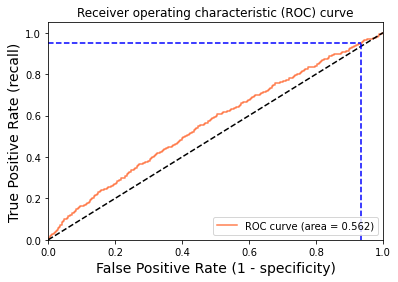

In [57]:
import numpy as np
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensibility > 0.95
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

**AUROC** (Area Under the Receiver Operating Characteristics)
The more the area enclosed by the ROC curve, the better it is. The area under the curve can lie between 0 and 1. The closer it is to 1, the better it is

###### 3.4 Random Forest

**Ensemble learning**, in general, is a model that makes predictions based on a number of different models. By combining individual models, the ensemble model tends to be more flexible (less bias) and less data-sensitive (less variance)
Two most popular ensemble methods are bagging and boosting.

**Bagging**: Training a bunch of individual models in a parallel way. Each model is trained by a random subset of the data => bootstrapping the data plus using the aggregate to make a decision is called bagging!

- **Random forest** is an ensemble model using bagging as the ensemble method and decision tree as the individual model.

**Boosting**: Training a bunch of individual models in a sequential way. Each individual model learns from mistakes made by the previous model

- **Gradient Boosting**: GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree. GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

1.Create the classifier(object):

In [58]:
rf_model = RandomForestClassifier(
   n_estimators=200,
    max_depth=5)

2.Train the model on training data:

In [59]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200)

3.Make the prediction:

In [60]:
rf_model_pred = rf_model.predict_proba(x_test)
y_pred_proba=rf_model_pred[:,1]
y_pred_proba

array([0.05757971, 0.13336961, 0.14290489, ..., 0.17055502, 0.19339283,
       0.15164095])

4.Show the ROC_CURVE to evaluate the model performance:

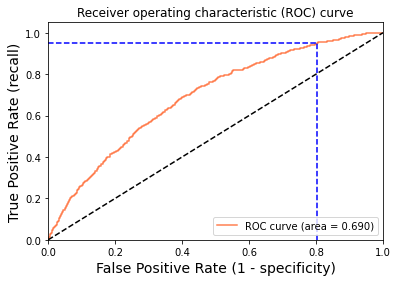

In [61]:
import numpy as np
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensibility > 0.95
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Get the feature importances for each feature using the following code:

In [62]:
rf_model.feature_importances_

array([4.61377971e-02, 2.97105362e-02, 1.62231988e-01, 3.89757400e-02,
       7.30151978e-02, 2.98122869e-03, 2.98329504e-02, 3.61074199e-03,
       4.64316499e-02, 2.09856563e-02, 2.51282204e-02, 1.59478493e-02,
       2.81354984e-02, 5.98684273e-02, 3.44167034e-02, 0.00000000e+00,
       9.33163593e-03, 4.70999082e-02, 6.17266104e-02, 0.00000000e+00,
       9.07662583e-02, 1.07515734e-02, 7.77978981e-03, 2.16740452e-02,
       2.50193546e-02, 1.96116262e-02, 8.08726743e-03, 0.00000000e+00,
       5.54558102e-03, 0.00000000e+00, 1.35893766e-03, 3.18257423e-03,
       3.12336399e-03, 0.00000000e+00, 7.65486750e-04, 5.06130129e-04,
       4.38679604e-04, 7.66545059e-04, 4.47092865e-03, 7.14533917e-04,
       8.97249147e-04, 6.27451235e-04, 8.43911819e-04, 9.69664434e-03,
       3.10051500e-03, 2.98018765e-03, 0.00000000e+00, 7.03180003e-05,
       1.16219812e-03, 1.30180874e-05, 7.13557020e-04, 3.93950967e-04,
       1.94544262e-03, 1.01483709e-03, 9.23024250e-04, 0.00000000e+00,
      

Associate these feature importances with the corresponding features:

In [63]:
feature_importance_df = pd.DataFrame(list(zip(rf_model.feature_importances_, list(x_train.columns))))
feature_importance_df.columns = ['feature.importance', 'feature']
feature_importance_df.sort_values(by='feature.importance', ascending=False).head(20) # only show top 20

,feature.importance,feature
2,0.162232,int_rate
20,0.090766,grade_A
4,0.073015,annual_inc
18,0.061727,term_60 months
13,0.059868,revol_util
17,0.047100,term_36 months
8,0.046432,inq_last_6mths
0,0.046138,Unnamed: 0
3,0.038976,installment
14,0.034417,total_acc
